In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-10 12:46:25.144889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25(i) dataset @2.4GHz

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/D-25/Device-25(i)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[ 0.046875 -0.0546875j  0.0703125+0.0078125j -0.015625 -0.078125j  ...
 -0.0390625-0.1640625j -0.078125 -0.0234375j  0.0234375-0.0078125j]
2048
75193
(2048, 75193)
[0.02891908 0.01625739 0.00515618 ... 0.00561692 0.00572858 0.01698964]
0
(10000, 2048)
(10000,)
[ 0.046875 +0.0078125j -0.0859375+0.015625j   0.078125 -0.03125j   ...
  0.09375  -0.015625j  -0.015625 -0.0625j    -0.0234375-0.0859375j]
2048
71536
(2048, 71536)
[0.02900774 0.01949993 0.00782374 ... 0.0054048  0.0065753  0.01679224]
1
(20000, 2048)
(20000,)
[-0.015625 -0.0390625j  0.046875 -0.046875j   0.0078125+0.015625j  ...
  0.       +0.0078125j -0.0078125-0.0546875j -0.0390625-0.03125j  ]
2048
79948
(2048, 79948)
[0.02881636 0.01655435 0.00561349 ... 0.00583372 0.00589733 0.01669759]
2
(30000, 2048)
(30000,)
[ 0.0546875+0.046875j  -0.015625 -0.0078125j  0.0625   -0.015625j  ...
 -0.0234375-0.125j      0.0546875+0.046875j   0.       -0.0546875j]
2048
85725
(2048, 85725)
[0.0291865  0.01664384 0.00656994 ... 0.00673976 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(ii) model to Nordic Device-25(i) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

2023-04-03 12:07:13.172084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 4.2500 - accuracy: 0.4395
test loss, test acc: [4.250006675720215, 0.43950000405311584]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 4 ... 2 1 1]
0
[[9964    2    0    0   31    0    0    3]
 [   1 5517    0 1687    1   74 2718    2]
 [   0  688 5308    1    4 3997    2    0]
 [   5  132    2 9729   12    3  113    4]
 [   0 9285   28   24    3  639   20    1]
 [   3   28 5331    4    5 4610   19    0]
 [  32 9273    2  602   23   19   29   20]
 [   4 8750  928   13  281   24    0    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       0.16      0.55      0.25     10000
           2       0.46      0.53      0.49     10000
           3       0.81      0.97      0.88     10000
           4       0.01      0.00      0.00     10000
           5       0.49      0.46      0.48     10000
           6       0.01      0.00      0.00     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.44     80000
   macro avg       0.37      0.44  

Test Accuracy:0.4395


Text(0.5, 1.0, 'Accuracy:0.440')

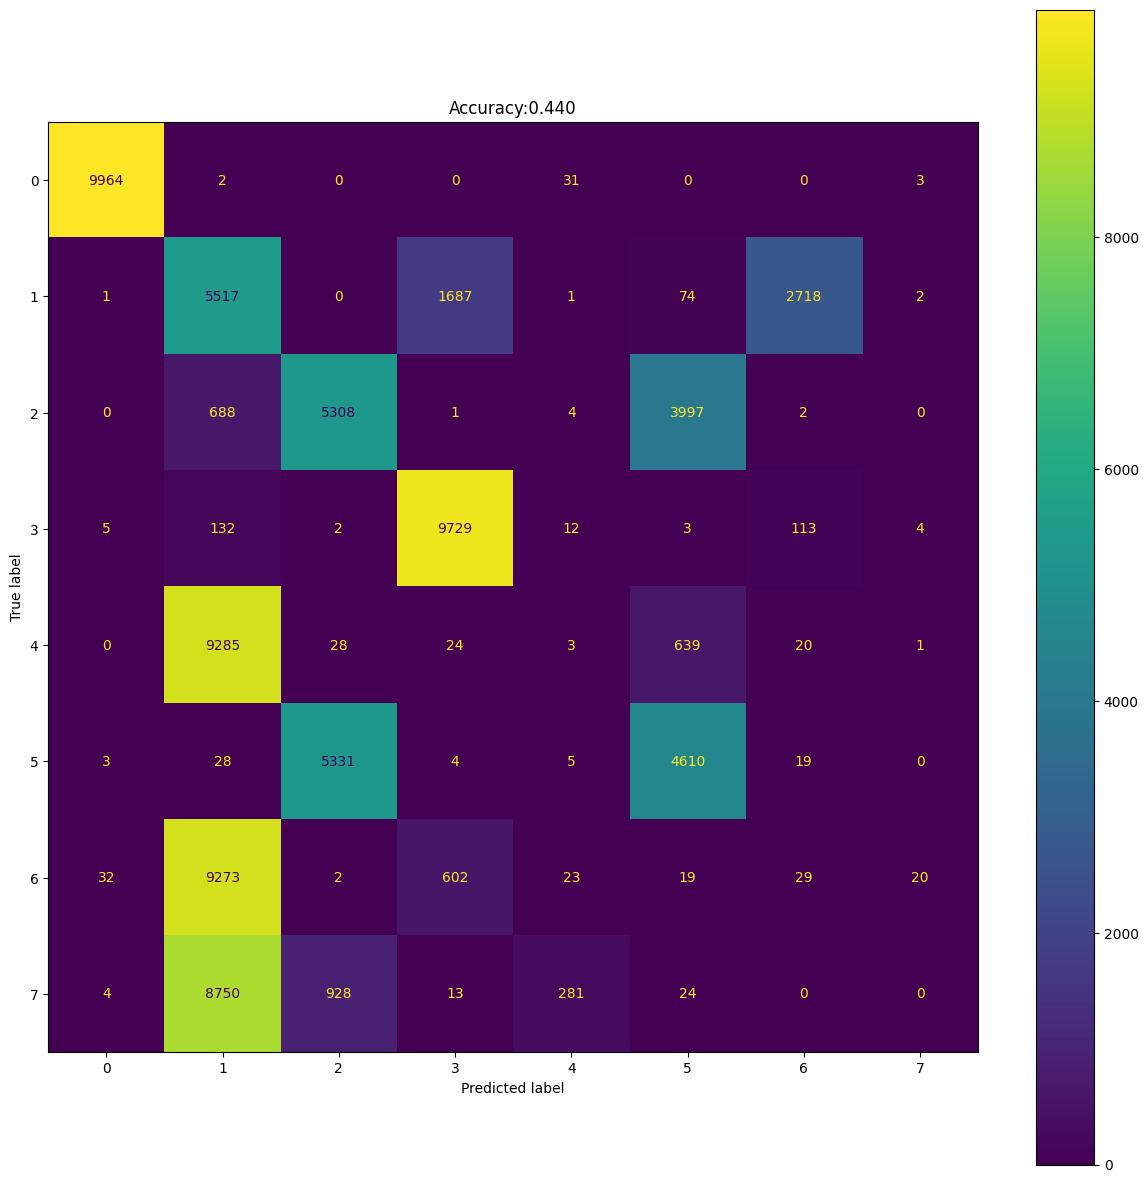

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(ii) model to Nordic Device-25(i) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.5053 - accuracy: 0.5078
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5063 - accuracy: 0.8843
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4051 - accuracy: 0.9252
Epoch 4/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.3706 - accuracy: 0.9331
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3498 - accuracy: 0.9359
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3351 - accuracy: 0.9378
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3238 - accuracy: 0.9385
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.3147 - accuracy: 0.9394
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3072 - accuracy: 0.9396
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

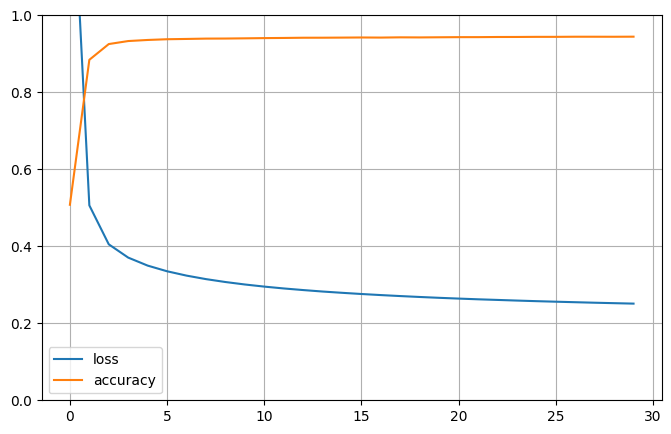

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2504 - accuracy: 0.9445
test loss, test acc: [0.2503855228424072, 0.9445375204086304]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[0 0 7 ... 7 7 7]
0
[[9963    0    0    0    0    0    4   33]
 [   1 9182    1  313  306    4  192    1]
 [   0    8 9201    1  162  489    5  134]
 [   4  338    3 9530    6    0  114    5]
 [   0  247  233   13 9248   17  110  132]
 [   2   44  381    3   17 9528    9   16]
 [  11  296    2   97  152    4 9330  108]
 [   2    2  124    7  168    9  107 9581]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       0.91      0.92      0.91     10000
           2       0.93      0.92      0.92     10000
           3       0.96      0.95      0.95     10000
           4       0.92      0.92      0.92     10000
           5       0.95      0.95      0.95     10000
           6       0.95      0.93      0.94     10000
           7       0.96      0.96      0.96     10000

    accuracy                           0.94     80000
   macro avg       0.94      0.94  

Test Accuracy:0.9445375


Text(0.5, 1.0, 'Accuracy:0.945')

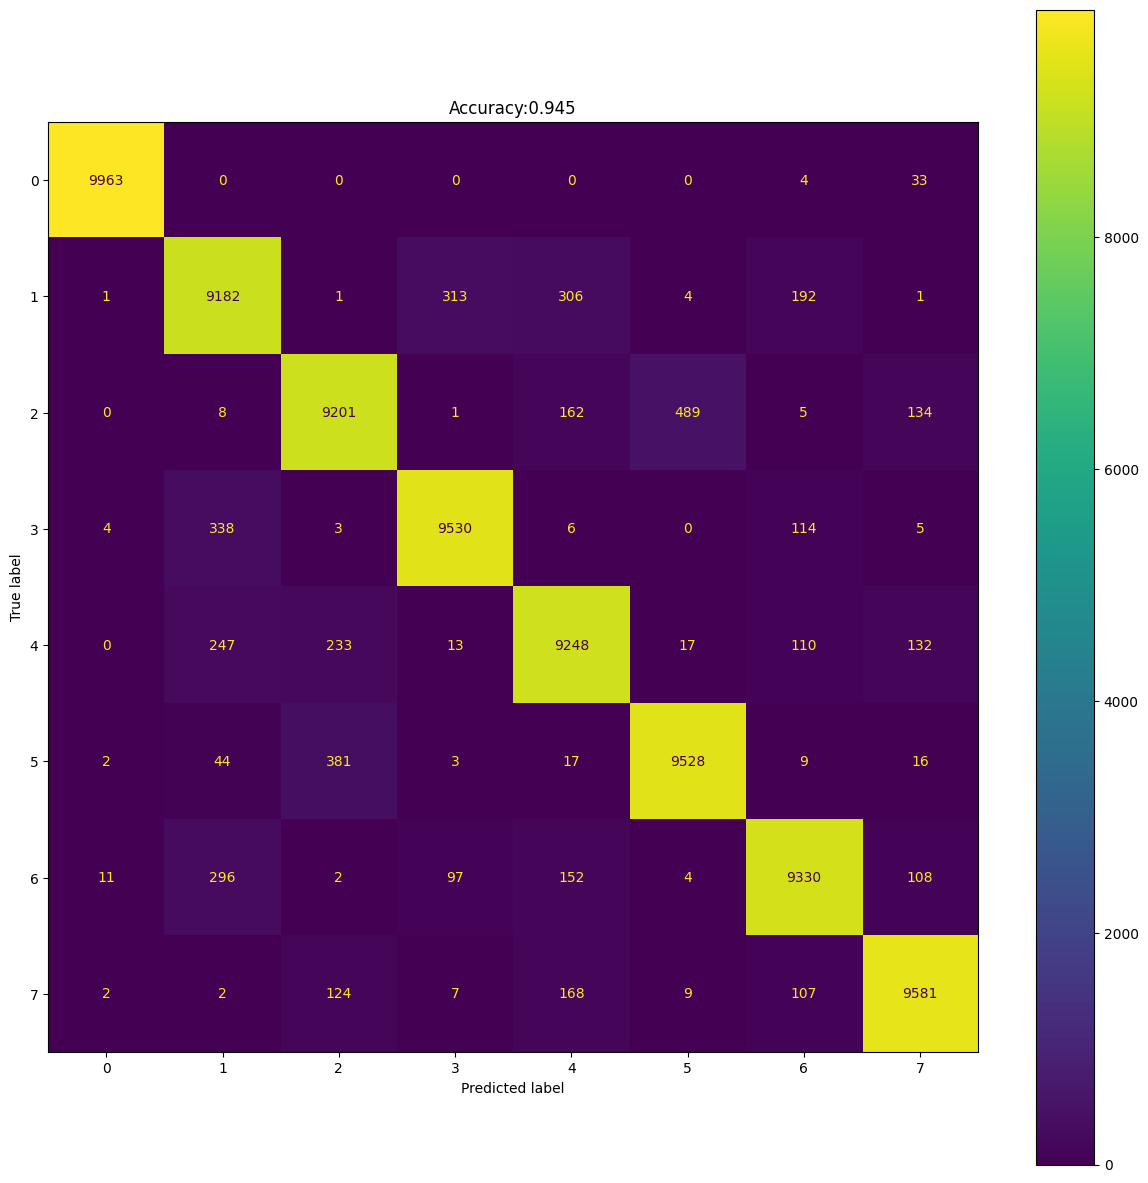

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-25(i) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 3.9051 - accuracy: 0.2107
test loss, test acc: [3.9050793647766113, 0.21068750321865082]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 0 7 ... 7 1 1]
4
[[7240    0 2719    0   19    0    0   22]
 [   0 1747    0    3  728    3 7519    0]
 [   2   92    1    1   52   68    2 9782]
 [   0  225    0  202    4    0 9569    0]
 [   0 9299    0    3   14  582   22   80]
 [   9   24    3    4   44   38   29 9849]
 [  11   81   38    0 9646    1  218    5]
 [   5 2408    0    0  125   62    5 7395]]
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     10000
           1       0.13      0.17      0.15     10000
           2       0.00      0.00      0.00     10000
           3       0.95      0.02      0.04     10000
           4       0.00      0.00      0.00     10000
           5       0.05      0.00      0.01     10000
           6       0.01      0.02      0.02     10000
           7       0.27      0.74      0.40     10000

    accuracy                           0.21     80000
   macro avg       0.30      0.21  

Test Accuracy:0.2106875


Text(0.5, 1.0, 'Accuracy:0.211')

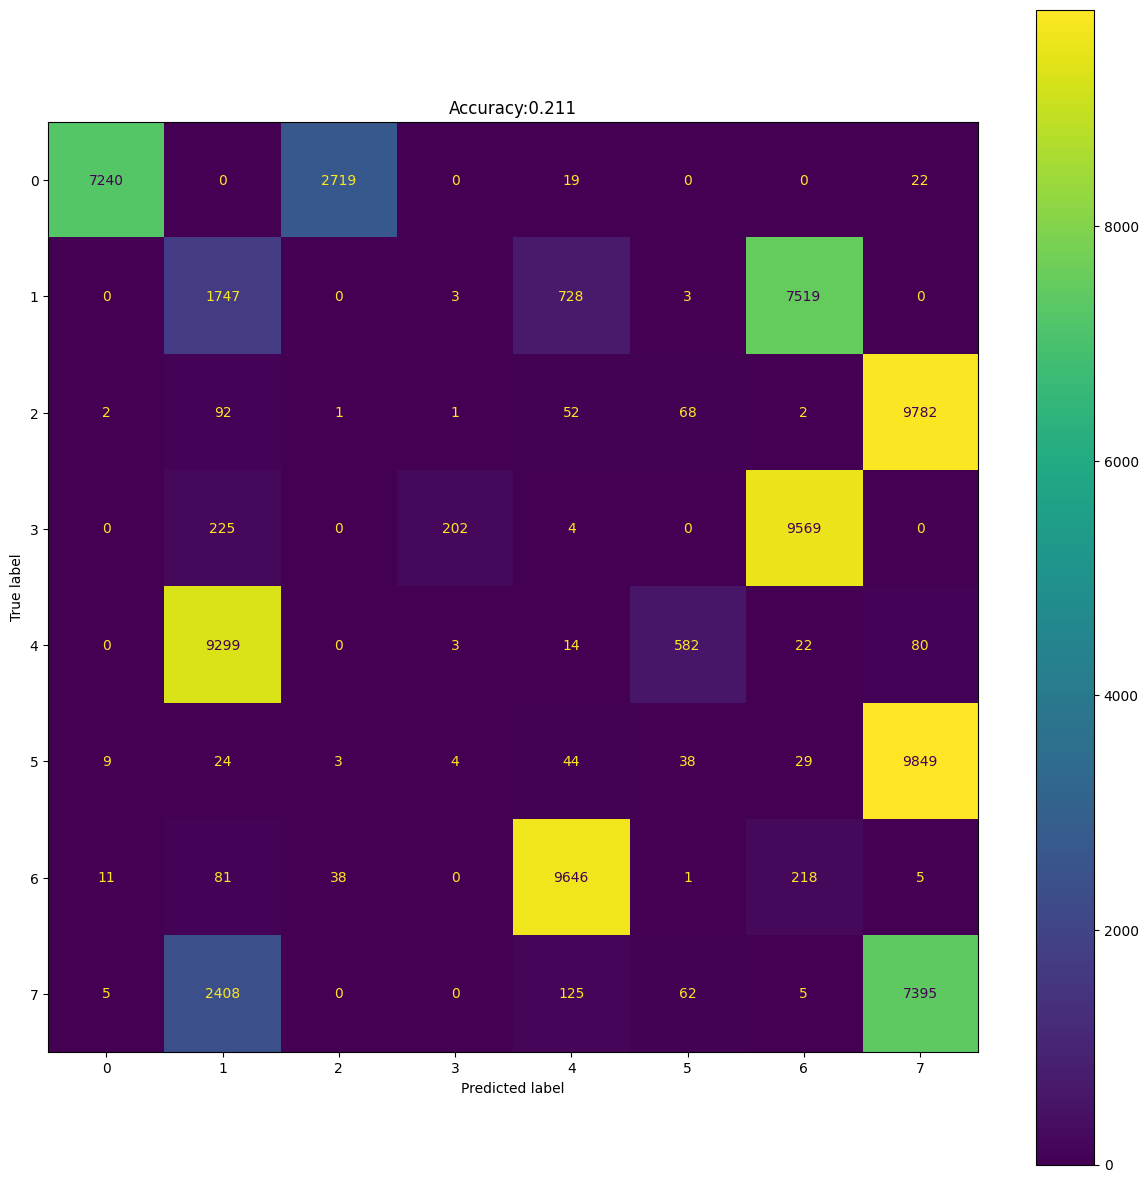

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(iii) model to Nordic Device-25(i) dataset 

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.0425 - accuracy: 0.6186
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4729 - accuracy: 0.8510
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3979 - accuracy: 0.8866
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3607 - accuracy: 0.9039
Epoch 5/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.3367 - accuracy: 0.9144
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3199 - accuracy: 0.9215
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3072 - accuracy: 0.9270
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2970 - accuracy: 0.9305
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2889 - accuracy: 0.9338
Epoch 10/30
2500/2500 [==============================] - 11s 5ms/step - l

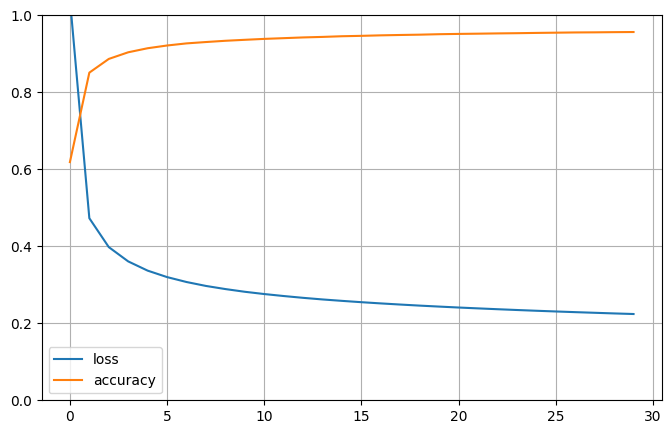

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 0.2230 - accuracy: 0.9571
test loss, test acc: [0.22297219932079315, 0.9571124911308289]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[6 0 5 ... 7 7 7]
6
[[9956    0    0    0    0   36    5    3]
 [   0 9835    0   57   70    0   33    5]
 [   2    5 8910    2   56  708   19  298]
 [   0   56    0 9875   60    0    8    1]
 [   0   23   31   16 9781    3    9  137]
 [  12   23  845   23   31 9035   28    3]
 [  10  102    1   17   37    3 9785   45]
 [   0   16  346    1  175   49   21 9392]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       0.98      0.98      0.98     10000
           2       0.88      0.89      0.89     10000
           3       0.99      0.99      0.99     10000
           4       0.96      0.98      0.97     10000
           5       0.92      0.90      0.91     10000
           6       0.99      0.98      0.98     10000
           7       0.95      0.94      0.94     10000

    accuracy                           0.96     80000
   macro avg       0.96      0.96  

Test Accuracy:0.9571125


Text(0.5, 1.0, 'Accuracy:0.957')

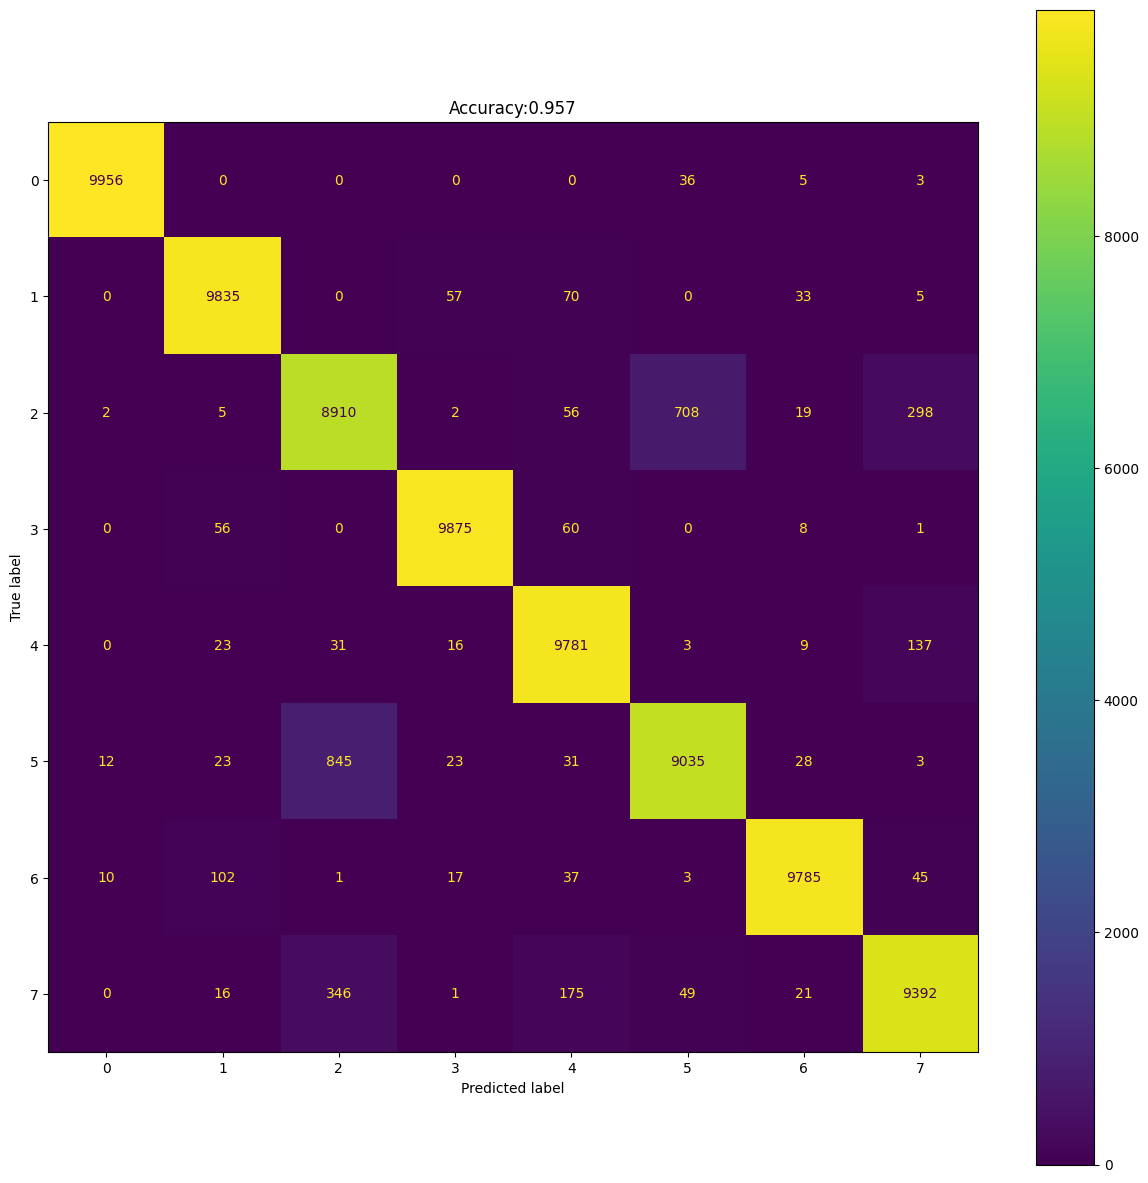

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-30(i) model to Nordic Device-25(i) dataset 

In [27]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [28]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 34.1774 - accuracy: 0.2009
test loss, test acc: [34.17739486694336, 0.2008875012397766]


In [29]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[3 4 4 ... 4 4 4]
3
[[   0   10    0    5 9985    0    0    0]
 [   3    0 1724 7917  353    1    1    1]
 [   2    5    3   30 9950    1    8    1]
 [   6    0  287 9477  195    0   32    3]
 [   1    5   15 3373 6588    0   17    1]
 [   0   25    3   61 9896    0   15    0]
 [   5    3    4  143 9841    0    2    2]
 [   0   48    2   73 9850    0   26    1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.00      0.00      0.00     10000
           3       0.45      0.95      0.61     10000
           4       0.12      0.66      0.20     10000
           5       0.00      0.00      0.00     10000
           6       0.02      0.00      0.00     10000
           7       0.11      0.00      0.00     10000

    accuracy                           0.20     80000
   macro avg       0.09      0.20  

Test Accuracy:0.2008875


Text(0.5, 1.0, 'Accuracy:0.201')

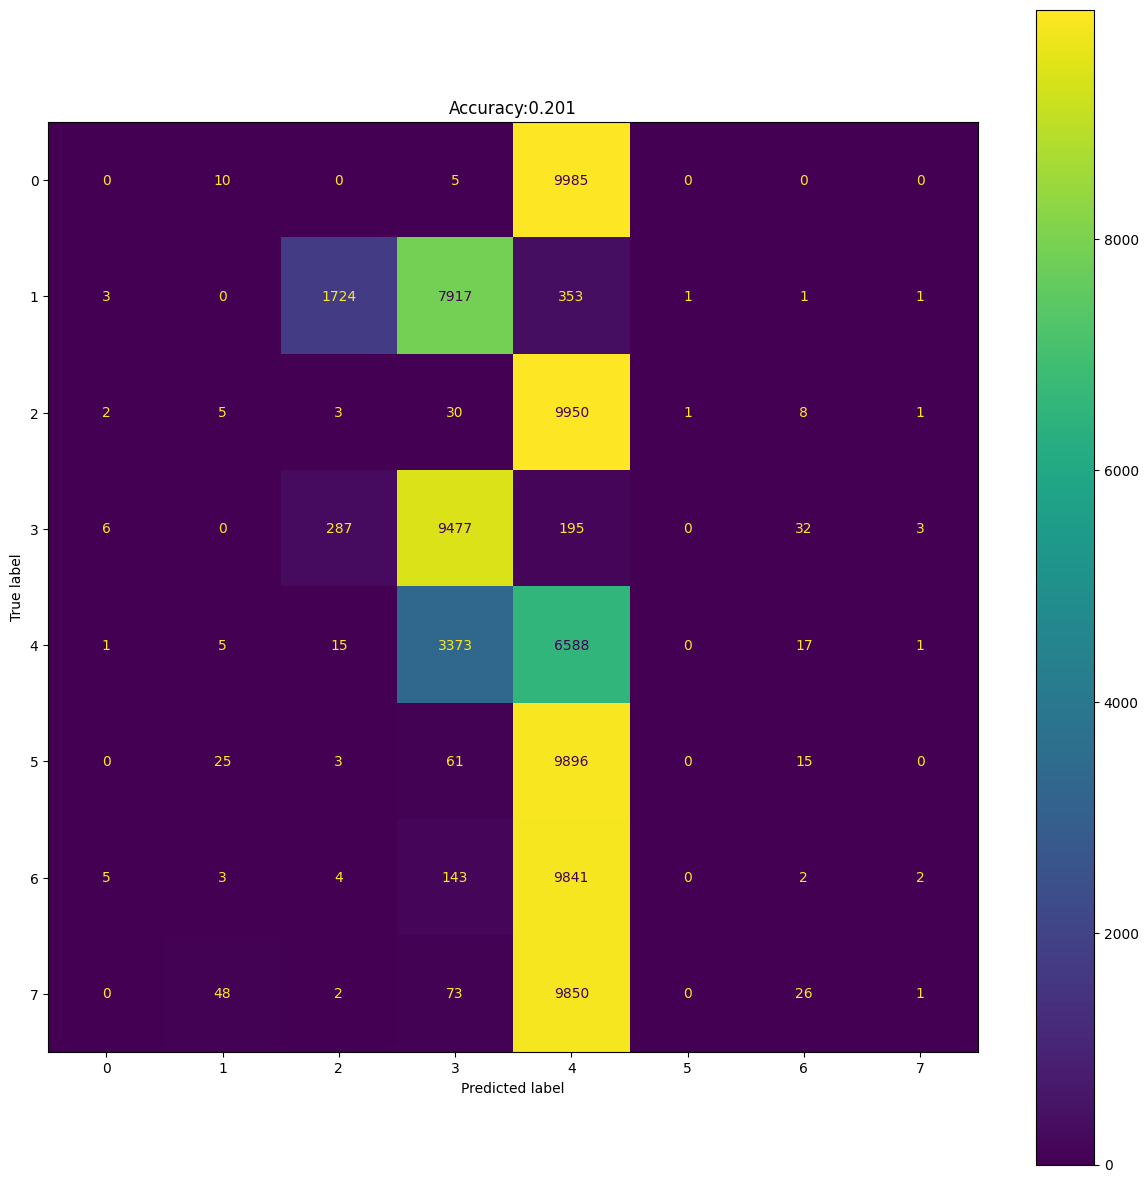

In [30]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [31]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [32]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [33]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 4ms/step - loss: 3.9327 - accuracy: 0.2654
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.0310 - accuracy: 0.6944
Epoch 3/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.7983 - accuracy: 0.8052
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.7076 - accuracy: 0.8347
Epoch 5/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.6544 - accuracy: 0.8495
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6182 - accuracy: 0.8574
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5907 - accuracy: 0.8634
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5692 - accuracy: 0.8679
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5515 - accuracy: 0.8713
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

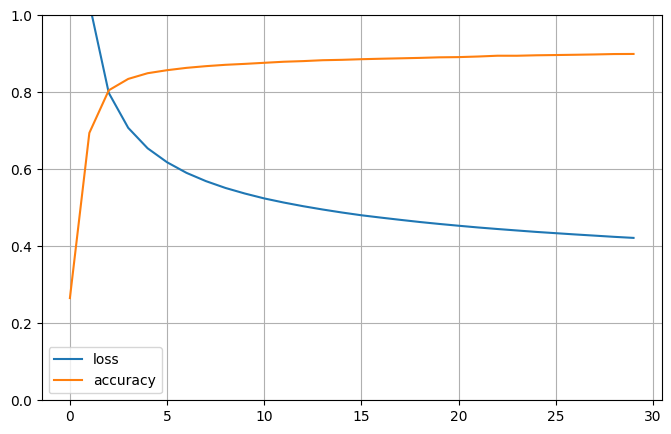

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [35]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.4205 - accuracy: 0.9004
test loss, test acc: [0.42053094506263733, 0.9004499912261963]


In [36]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[1 5 2 ... 7 7 7]
1
[[9462    5   18    0    2  434   76    3]
 [   0 9665    0  260   56    0   17    2]
 [  12    7 7920   10   36  246  276 1493]
 [   0  449    4 9338  158    0   34   17]
 [   0   22    6   72 9390   13  238  259]
 [  85    4  592   16   63 9076    6  158]
 [   6   26  395   34  397    3 8870  269]
 [  12    1 1333    6  104  125  104 8315]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     10000
           1       0.95      0.97      0.96     10000
           2       0.77      0.79      0.78     10000
           3       0.96      0.93      0.95     10000
           4       0.92      0.94      0.93     10000
           5       0.92      0.91      0.91     10000
           6       0.92      0.89      0.90     10000
           7       0.79      0.83      0.81     10000

    accuracy                           0.90     80000
   macro avg       0.90      0.90  

Test Accuracy:0.90045


Text(0.5, 1.0, 'Accuracy:0.900')

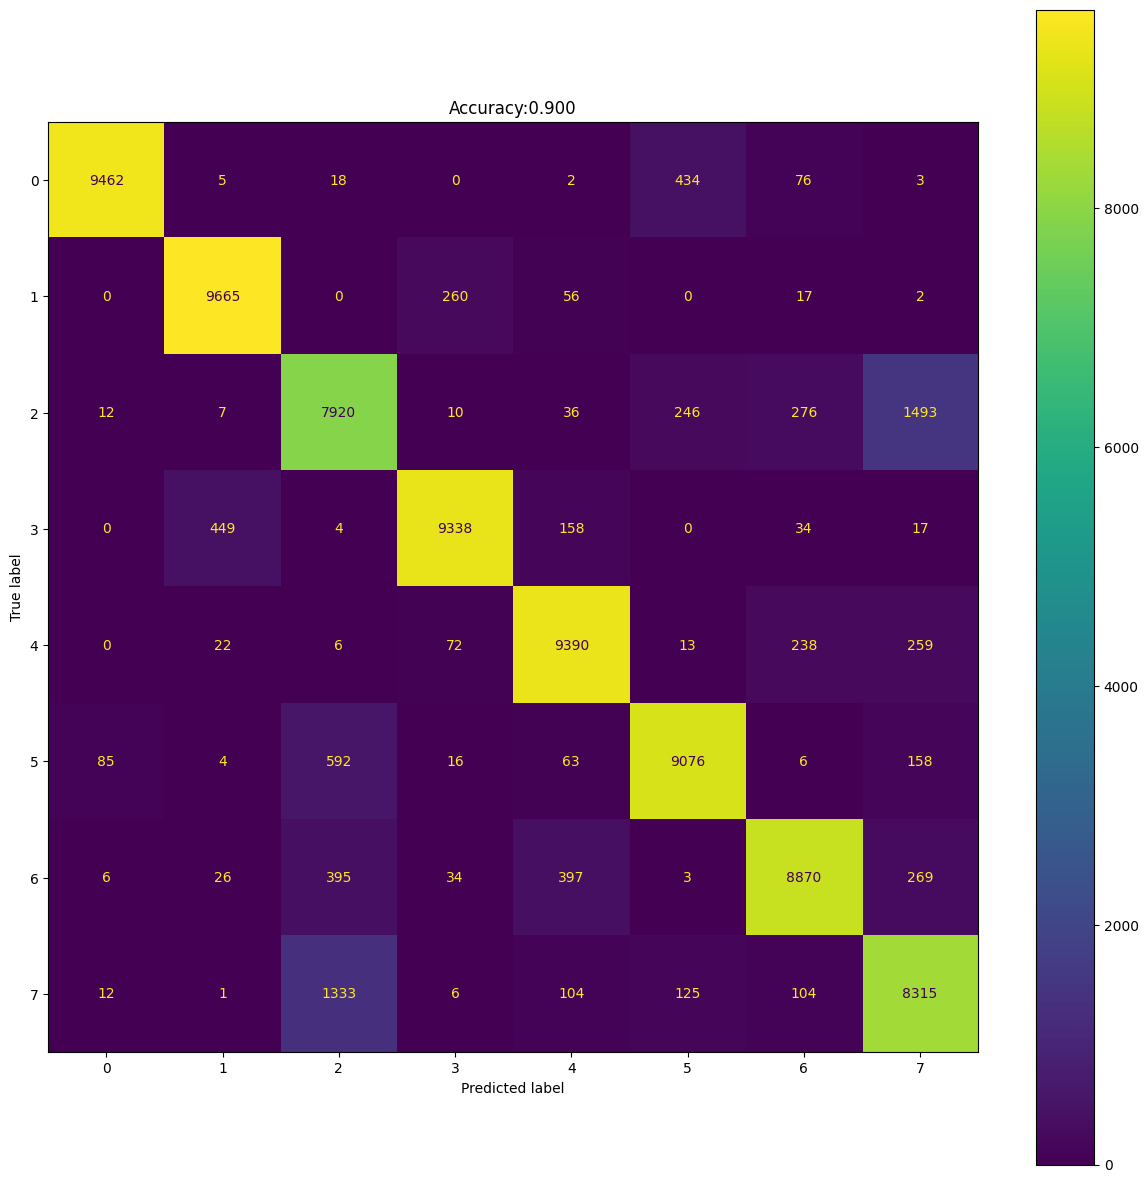

In [37]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-25(i) dataset 

In [38]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [39]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 23.6191 - accuracy: 0.0043
test loss, test acc: [23.6191463470459, 0.004275000188499689]


In [40]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[4 1 1 ... 3 1 1]
4
[[   0 4892    0   89 5019    0    0    0]
 [2439  137    4 7372   34    9    4    1]
 [  13 1040    1 8945    0    0    0    1]
 [9747    9   14  180   17   23    7    3]
 [ 138  444    4 9402    7    5    0    0]
 [   9 9923    0   12   39   17    0    0]
 [  99  625    5 9159  106    5    0    1]
 [  21 7159    4 2807    7    2    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.01      0.01      0.01     10000
           2       0.03      0.00      0.00     10000
           3       0.00      0.02      0.01     10000
           4       0.00      0.00      0.00     10000
           5       0.28      0.00      0.00     10000
           6       0.00      0.00      0.00     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.00     80000
   macro avg       0.04      0.00  

Test Accuracy:0.004275


Text(0.5, 1.0, 'Accuracy:0.004')

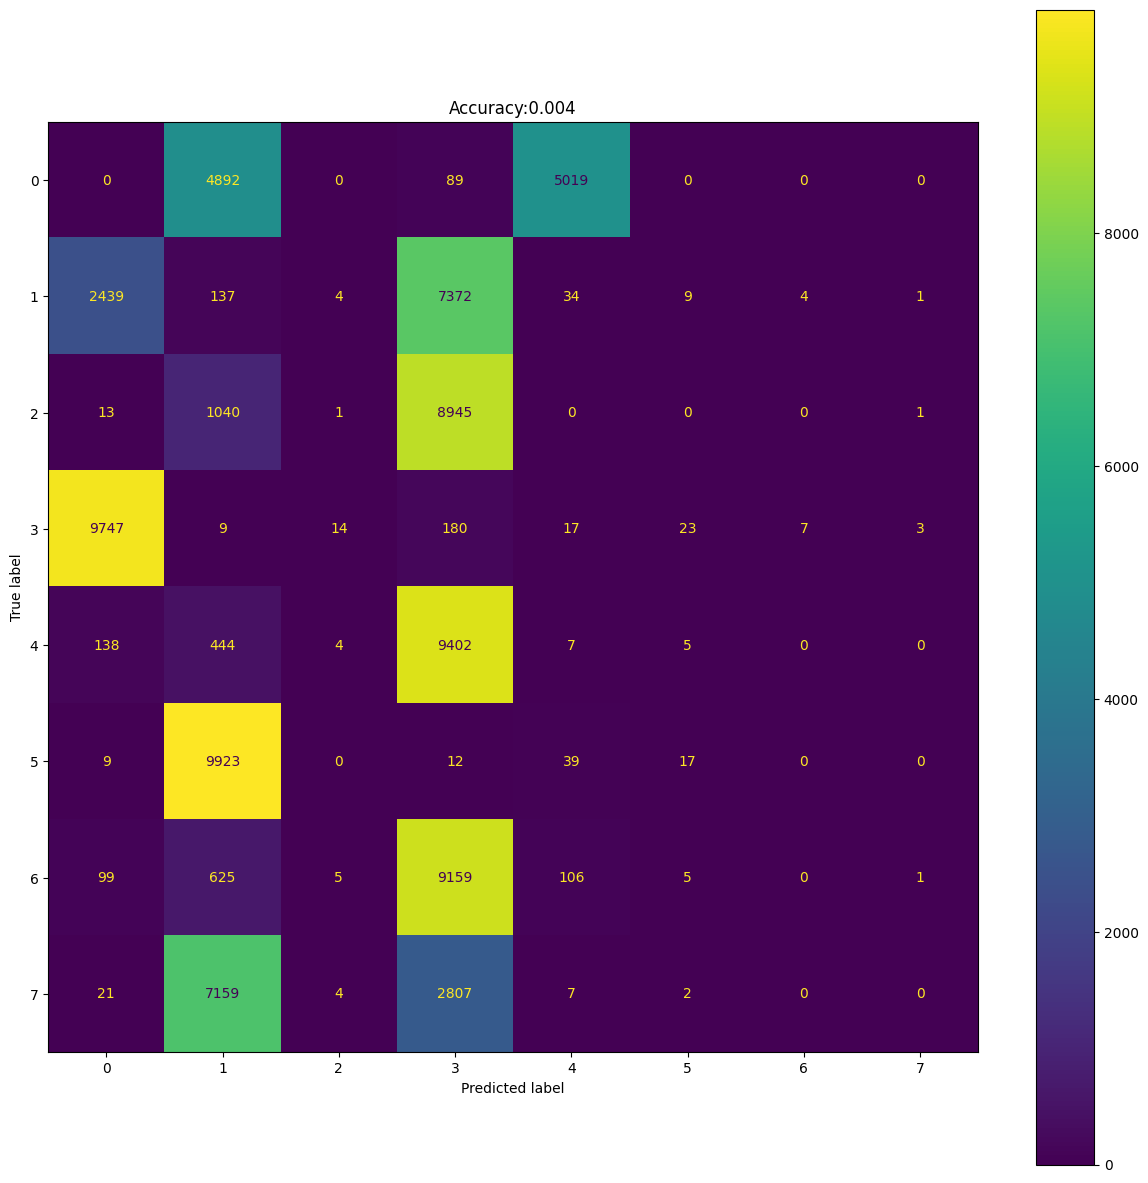

In [41]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [42]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [43]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [44]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 14s 5ms/step - loss: 3.0687 - accuracy: 0.2673
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.9915 - accuracy: 0.6687
Epoch 3/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.7552 - accuracy: 0.8568
Epoch 4/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.6434 - accuracy: 0.9093
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5743 - accuracy: 0.9272
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5259 - accuracy: 0.9362
Epoch 7/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.4898 - accuracy: 0.9411
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4616 - accuracy: 0.9446
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4389 - accuracy: 0.9476
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

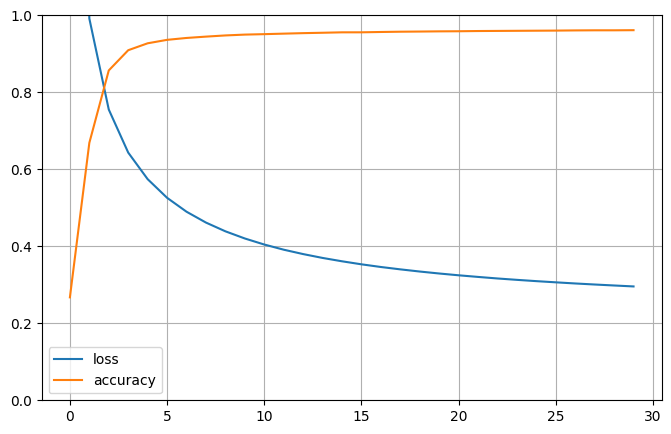

In [45]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [47]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2942 - accuracy: 0.9617
test loss, test acc: [0.29422277212142944, 0.9617000222206116]


In [48]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[6 0 5 ... 7 7 7]
6
[[9889    0    1    0    0   33   67   10]
 [   8 9205    0  332  265    1  182    7]
 [   0    4 9831   15   23   53   15   59]
 [   1  292    1 9654   40    0   11    1]
 [   7  154   15  129 9541   42   28   84]
 [  40   34   32   11    7 9839   13   24]
 [  15  182   12   74   78    0 9510  129]
 [  10   16  178   14  109   90  116 9467]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10000
           1       0.93      0.92      0.93     10000
           2       0.98      0.98      0.98     10000
           3       0.94      0.97      0.95     10000
           4       0.95      0.95      0.95     10000
           5       0.98      0.98      0.98     10000
           6       0.96      0.95      0.95     10000
           7       0.97      0.95      0.96     10000

    accuracy                           0.96     80000
   macro avg       0.96      0.96  

Test Accuracy:0.9617


Text(0.5, 1.0, 'Accuracy:0.962')

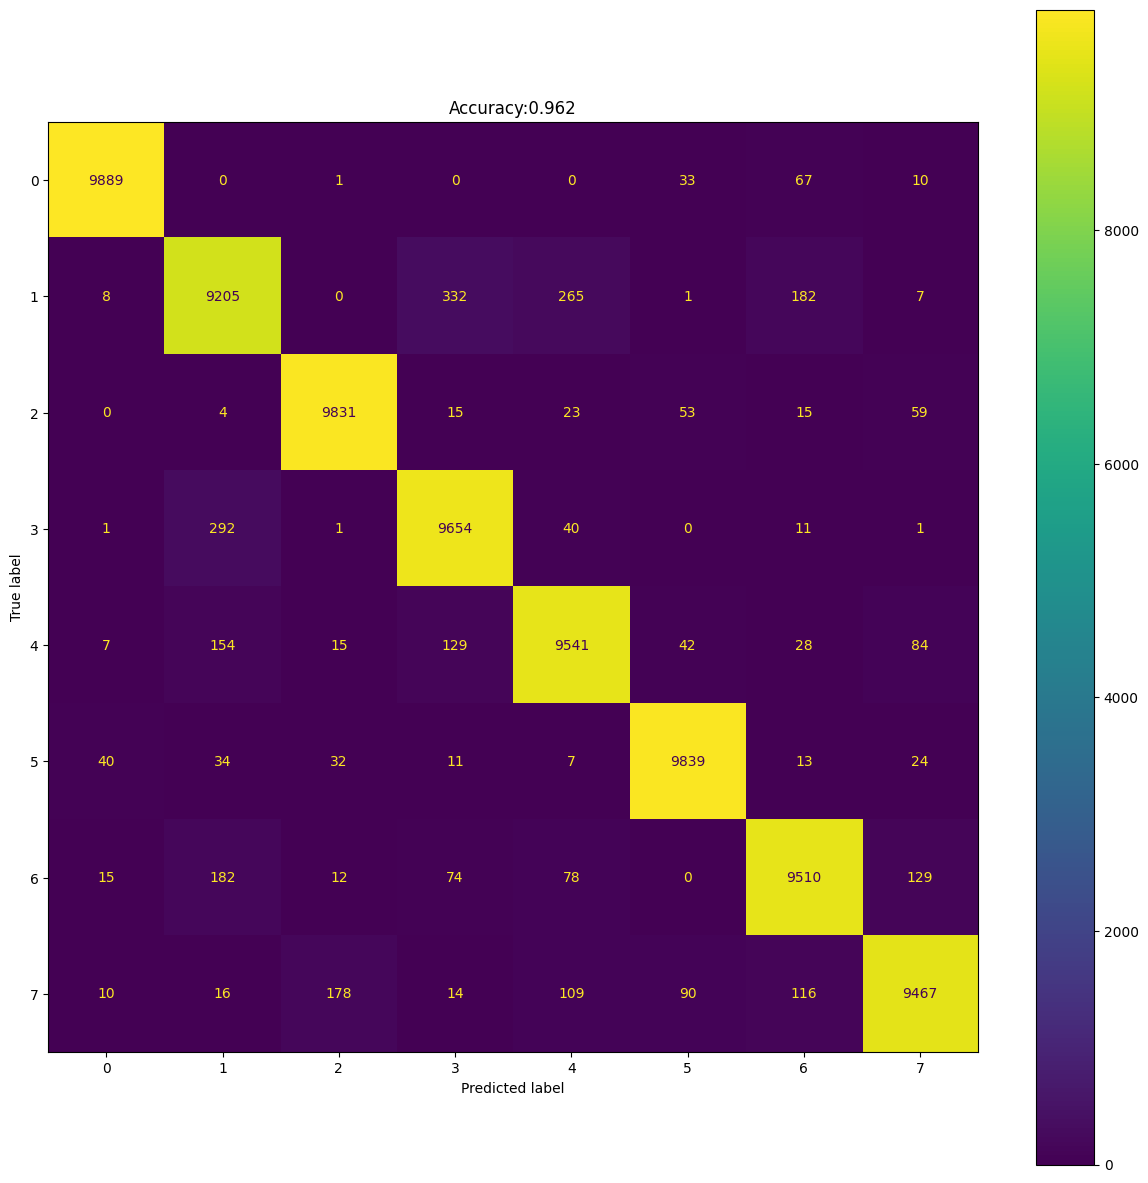

In [49]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-25(i) dataset 

In [50]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [51]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 18.2274 - accuracy: 0.1231
test loss, test acc: [18.227399826049805, 0.12308750301599503]


In [52]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[1 1 0 ... 1 1 1]
1
[[9062  937    0    1    0    0    0    0]
 [  42   16 9878   32   23    6    1    2]
 [6391 3593    9    2    3    2    0    0]
 [  19   33 9450   14  445   35    2    2]
 [  73 6720 2453    5  744    3    1    1]
 [  66 9859   39    1   27    2    6    0]
 [6429  915 2618   12   17    7    0    2]
 [ 505 9461   19    0   14    1    0    0]]
              precision    recall  f1-score   support

           0       0.40      0.91      0.56     10000
           1       0.00      0.00      0.00     10000
           2       0.00      0.00      0.00     10000
           3       0.21      0.00      0.00     10000
           4       0.58      0.07      0.13     10000
           5       0.04      0.00      0.00     10000
           6       0.00      0.00      0.00     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.15      0.12  

Test Accuracy:0.1230875


Text(0.5, 1.0, 'Accuracy:0.123')

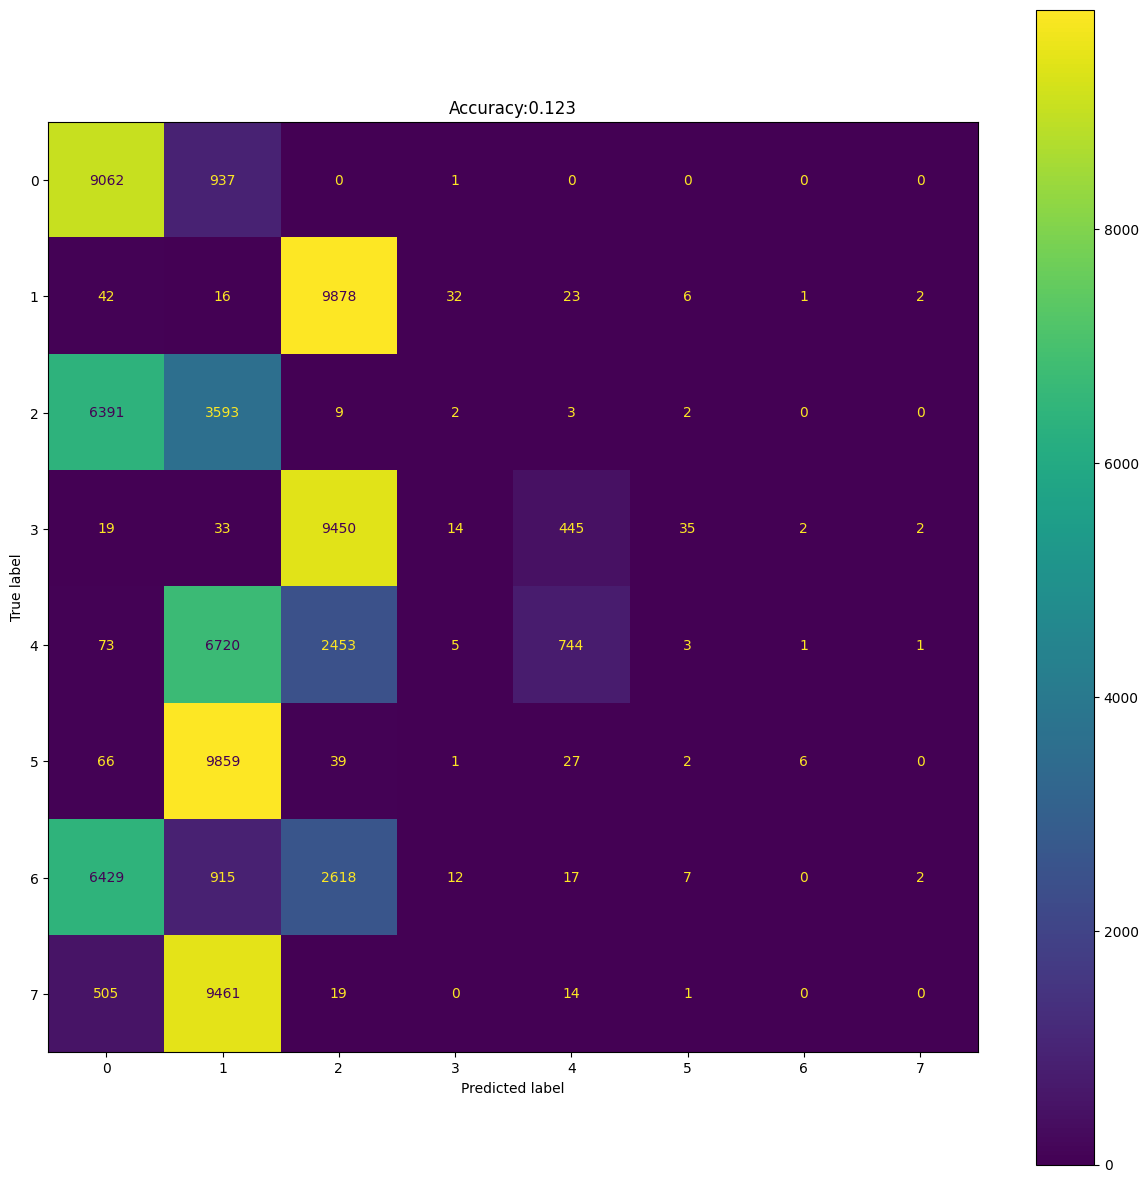

In [53]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [54]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [55]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [56]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.7817 - accuracy: 0.4022
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.8320 - accuracy: 0.7398
Epoch 3/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.6736 - accuracy: 0.8307
Epoch 4/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.6062 - accuracy: 0.8588
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5636 - accuracy: 0.8758
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5325 - accuracy: 0.8867
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5085 - accuracy: 0.8941
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4890 - accuracy: 0.8999
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4726 - accuracy: 0.9038
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

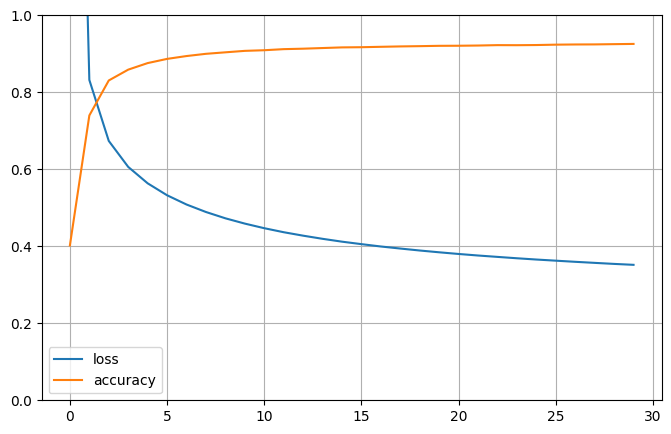

In [57]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [58]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.3509 - accuracy: 0.9245
test loss, test acc: [0.35085418820381165, 0.9244999885559082]


In [59]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 5 2 ... 7 7 7]
4
[[9630    2   45    0    1  305   17    0]
 [   2 9082    0  648   48    1  216    3]
 [  10    5 9370    7    4  193   43  368]
 [   2  849    2 8951  160    0   29    7]
 [   0   13    2  100 9723    3   52  107]
 [  67   16  221   47    9 9552   39   49]
 [   0  366   56   58  256   23 9043  198]
 [   1    1  906   12  132  158  181 8609]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10000
           1       0.88      0.91      0.89     10000
           2       0.88      0.94      0.91     10000
           3       0.91      0.90      0.90     10000
           4       0.94      0.97      0.96     10000
           5       0.93      0.96      0.94     10000
           6       0.94      0.90      0.92     10000
           7       0.92      0.86      0.89     10000

    accuracy                           0.92     80000
   macro avg       0.93      0.92  

Test Accuracy:0.9245


Text(0.5, 1.0, 'Accuracy:0.924')

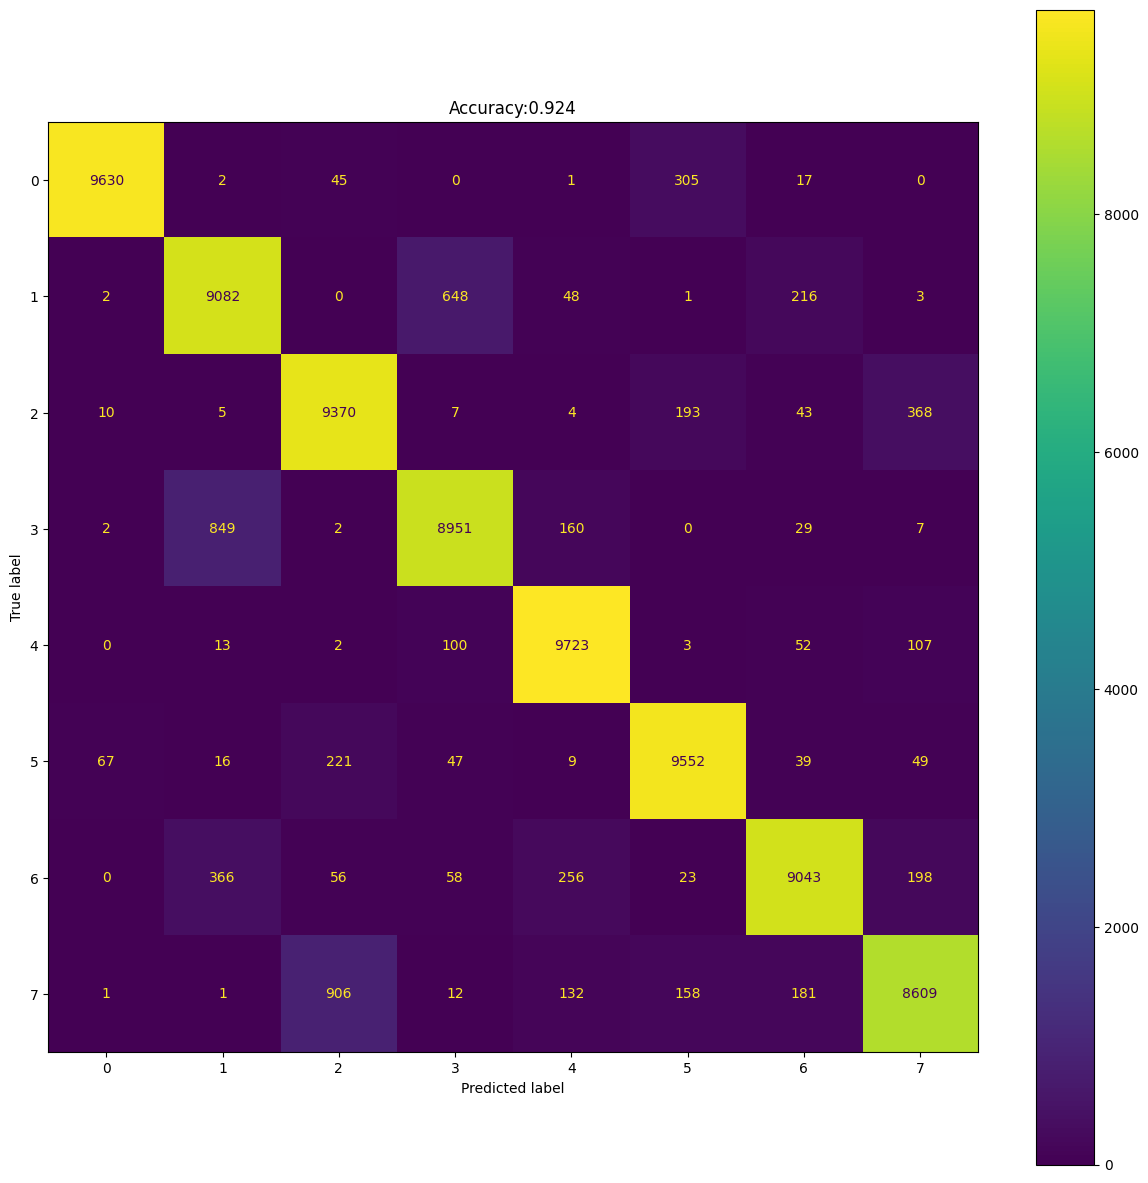

In [60]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')